# Comparing total hydrostatic masses measured by LoCuSS and XGA

This notebook measures hydrostatic masses for the samples we are using to verify our method, then compares them to the measurements from literature. These mass measurements include both the baryonic content of the intra-cluster medium, and that of the dark matter halo. This implicitly tests how close our measured temperature and density profiles are to those measured by the work we compare them to

The LoCuSS sample has hydrostatic mass measurements associated with them which we will compare to but the XXL-100-GC sample data is generally too shallow for such measurements.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.mass import inv_abel_dens_onion_temp
from xga.models import DoubleBetaProfile1D, SimpleVikhlininDensity1D, SimpleVikhlininTemperature1D

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [00:43<01:34,  2.96s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [00:57<01:29,  3.31s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  50%|██████████████████████                      | 25/50 [00:59<00:56,  2.24s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source RXCJ1212.3-1816 does not appear to have any XMM dat

## Reading in literature data

###   $\color{red}{\text{Hydrostatic masses from literature}}$

In [4]:
loc_lit_m500s = [locuss[locuss['name'] == n].iloc[0][['x_m500', 'x_m500_err', 'x_m500_err']].values
               for n in locuss_srcs.names]
loc_lit_m500s = Quantity(loc_lit_m500s, 'Msun')

loc_lit_m2500s = [locuss[locuss['name'] == n].iloc[0][['x_m2500', 'x_m2500_err', 'x_m2500_err']].values
               for n in locuss_srcs.names]
loc_lit_m2500s = Quantity(loc_lit_m2500s, 'Msun')

## Hydrostatic Mass Comparison to Literature

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.3$R_{500}$

In [5]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [6]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [7]:
demo_t_mod = SimpleVikhlininTemperature1D()
demo_t_mod.info()
demo_t_mod.par_priors

╒════════════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                     │
╞════════════════════════════════╪═════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Temperature                                                     │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ keV                                                                 │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ r_cool, a_cool, t_min, t_zero, r_tran, c_power                      │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ kpc, , keV, keV, kpc

[{'prior': <Quantity [ 10., 500.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [0.1, 6. ] keV>, 'type': 'uniform'},
 {'prior': <Quantity [ 0.5, 15. ] keV>, 'type': 'uniform'},
 {'prior': <Quantity [100., 500.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'}]

In [8]:
loc_sb_dblbeta_simpvikh_13_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.3, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

Running XSPEC Fits: 100%|█████████████████████████████████████████████████| 601/601 [1:03:30<00:00,  6.34s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0773 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell1451 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell1914 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit 

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1007.33481806 1626.44794911 1712.51089632 1667.95405985 1760.83891496
 1857.93283628]


Fitting data, inverse Abel transforming, and measuring densities:   6%|▍       | 2/36 [00:52<14:48, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1373.66879241  824.01089466 1697.101227   1639.51352789 1735.38513326
 1679.67404978]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▋       | 3/36 [01:16<13:48, 25.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 583.97793862 1090.39508635 1128.24569026 1092.91984418 1182.32763427
 1362.80022957]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▉       | 4/36 [01:41<13:24, 25.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [257.41580099 408.05399224 150.0931286  185.27672769 280.30484059
 297.37577003]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▎      | 6/36 [02:34<13:00, 26.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 618.41596881  331.27900781 1970.25321968 1942.16796104 1999.03488696
 1939.61547626]


Fitting data, inverse Abel transforming, and measuring densities:  22%|█▊      | 8/36 [03:28<12:27, 26.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [422.60659379 405.19677065 325.85926012 302.98506051 321.03082203
 368.72818665]


Fitting data, inverse Abel transforming, and measuring densities:  25%|██      | 9/36 [03:57<12:20, 27.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [347.26653962 942.05876542 853.75704431 252.33313692 213.37448372
 237.07991275]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 12/36 [05:14<10:30, 26.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1304.96135668  475.74045807 1448.54099975 1333.29953665 1404.50166321
 1355.97123035]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [890.87438729 272.82326749 856.9928768  689.58871416 777.64128755
 834.97991761]


Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 14/36 [06:09<09:50, 26.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [666.96684515 647.02172724 421.44147884 439.16604501 516.96779297
 653.95135476]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1167.90966289  719.68847583 1627.71187455 1142.09674892 1538.65095744
 1622.98377053]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 15/36 [06:35<09:18, 26.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1396.9052925   505.56499455 2199.36381874  788.13262204  637.98690261
 2192.58075104]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 19/36 [08:26<07:58, 28.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1513.29064931  915.6961012  2301.77433949 1009.14300509 1778.73055158
 2252.70618663]


Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 21/36 [09:23<07:13, 28.90s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell1758N's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 22/36 [09:47<06:21, 27.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1857.23879851  278.30446177 2041.30567089  534.66639673  436.46661652
 2037.72780185]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 26/36 [11:39<04:34, 27.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 693.24283821  775.42122264 1659.47322192  917.35151445 1120.35102749
 1640.92359546]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 28/36 [12:35<03:43, 27.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [267.83921188 418.96444587 395.31588895 360.15846884 393.9885942
 418.5201395 ]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 35/36 [15:55<00:27, 27.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [645.08063214 357.2592103  618.71205932 496.32824492 591.76609223
 684.33562733]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 36/36 [16:22<00:00, 27.29s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [570.77005876 457.48784452 533.96857892 348.15494368 439.25581439
 589.90943571]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 607.52820516 1038.67217144  574.78235662  821.88648831  358.67631394
  262.28381682]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.4196884  118.97856698 468.86694748 106.71333731 124.70736973
 176.18669106]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/45 [00:49<35:21, 49.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [330.2970457  710.40674557 371.88716571 468.99864006 293.6440359
 280.78291813]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/45 [01:37<21:30, 30.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [111.70961248 131.98745315 533.03402895 113.86341132 108.99159679
 276.76585617]


Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/45 [02:26<25:15, 36.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [275.74004711 910.63898364 834.2227103  370.26835771 331.91373421
 295.5630683 ]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/45 [03:14<27:01, 40.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [314.08025547 308.87242328 198.51986303 414.43005695 254.93201779
 255.74516887]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/45 [04:02<27:55, 42.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  92.37870062   94.7705135  1287.55322521  105.64841918  125.20328571
  100.95403102]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 731.3606323  1223.86409404 1599.3089877   563.20327566  704.37472191
 1455.39740541]


Generating Abell0267 hydrostatic mass profile:  16%|████▏                      | 7/45 [04:55<29:15, 46.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 319.56232061 1112.60487906 1275.53912768  386.72251882  217.56756543
  400.69164652]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  98.14811992   99.89141492 1114.21563181  103.13768427  123.51672721
  106.59531189]


Generating Abell0291 hydrostatic mass profile:  18%|████▊                      | 8/45 [05:44<29:03, 47.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [202.86495067 158.56381999 144.36099375 546.59900765 207.6347855
 626.45938014]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.38205284  90.20966757 400.57993244 111.56505664 115.9109369
  97.14636059]


Generating Abell0383 hydrostatic mass profile:  20%|█████▍                     | 9/45 [06:35<28:51, 48.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [633.89599219 752.46863304 710.79763238 609.33771958 327.62479759
 368.25911733]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 80.89901475  79.86616346 711.17652597  89.08672315  85.79856653
  83.5018048 ]


Generating Abell0521 hydrostatic mass profile:  22%|█████▊                    | 10/45 [07:28<28:55, 49.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [276.04542203 431.92764018 452.07202888 384.73555463 304.13122556
 279.90281217]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2052.02688677 2177.01324515 1596.98230407 2015.3228412  1859.07657512
 1691.64081452]


Generating Abell0586 hydrostatic mass profile:  24%|██████▎                   | 11/45 [08:17<28:02, 49.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [374.38676721 693.65389583 954.7754417  489.27753202 389.98495694
 524.14520399]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [101.57440222 100.28490556 460.36784067  96.93098216  82.6838766
  94.1647331 ]


Generating Abell0611 hydrostatic mass profile:  27%|██████▉                   | 12/45 [09:08<27:24, 49.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [310.32338118 669.45726924 510.47887659 505.15094932 258.04957771
 263.55760842]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 571.96605056  817.77470875 1066.99670781  377.79640813  222.37348655
  908.70053753]


Generating Abell0697 hydrostatic mass profile:  29%|███████▌                  | 13/45 [09:56<26:19, 49.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [425.33632897 924.95469811 284.48803945 576.02747485 294.40684699
 311.55541953]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.71793024 104.51333697 517.7103568  104.47224933 130.98644412
 173.71858675]


Generating Abell0750 hydrostatic mass profile:  33%|████████▋                 | 15/45 [11:39<25:18, 50.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 99.65745639 106.10520309 568.51056688 101.41467706 117.98151684
 104.87842178]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 865.36784191 1425.55510079 1698.94218772  344.9262151   336.80183683
  551.06932079]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1373.99822838 1390.48230581 1248.80077274 1426.83811278  940.31845943
 1327.67454539]


Generating Abell0781 hydrostatic mass profile:  38%|█████████▊                | 17/45 [12:30<23:42, 50.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 530.29083787  362.02467031  418.7705168   784.96673812  319.54352468
 1991.95826619]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1235.30447763 1226.87717643  566.74064187  843.78595212 1076.28784089
  817.91775317]


Generating Abell0901 hydrostatic mass profile:  40%|██████████▍               | 18/45 [13:17<17:11, 38.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [601.36031692 547.44967381 280.04442334 623.03105418 348.19237969
 355.13770713]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 80.24287179  82.91406009 660.05250112  77.16435644  80.05791378
  80.14519203]


Generating Abell0907 hydrostatic mass profile:  42%|██████████▉               | 19/45 [14:09<18:02, 41.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.16086092  89.35027205 415.1137603   84.9619099   83.52006151
  88.93176976]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  47%|█████████▎          | 21/45 [15:03<17:59, 44.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 933.27553615 1093.39338351  822.66795137 1013.86920818  393.32243722
  681.66416168]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 92.6225571   99.66545758 722.69129509  83.46384871  72.27858946
  69.94453088]


Generating Abell1689 hydrostatic mass profile:  53%|█████████████▊            | 24/45 [16:44<11:17, 32.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.31623953  81.62099429 553.66887716  86.88835499  93.7450337
  82.6304745 ]


Generating Abell1758N hydrostatic mass profile:  56%|█████████████▉           | 25/45 [17:42<12:32, 37.62s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:240: UserWarning: The density profile for Abell1758N could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating Abell1835 hydrostatic mass profile:  60%|███████████████▌          | 27/45 [17:42<11:17, 37.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [361.7078583  496.9346847  179.71828485 430.9360906  260.4079193
 301.90624312]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  64%|████████████▉       | 29/45 [18:37<07:36, 28.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.98561321 105.18262511 608.34343411 103.36600275 112.45941805
  94.77865193]


Generating ZwCl1459.4+4240 hydrostatic mass profile:  69%|█████████████▊      | 31/45 [20:24<07:37, 32.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [487.46913098 562.09874386 347.94063847 431.13192286 282.29874473
 261.69400808]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  71%|██████████████▏     | 32/45 [21:10<07:40, 35.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [679.17537967 694.38648487 790.97855188 673.1908616  400.07767897
 734.58524641]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  59.23221594   65.44026765 1017.93712735   83.00902227   86.08734259
   39.12528144]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▊    | 36/45 [24:04<06:08, 40.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [506.73453993 431.24860266 181.88397276 509.42498621 244.97648659
 352.65499153]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.65243868  77.84145356 574.06213912  82.08632107  72.70019842
  62.71126667]


Generating Abell2261 hydrostatic mass profile:  82%|█████████████████████▍    | 37/45 [25:02<05:59, 44.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.84213305  84.6367148  408.59737277  86.97455414  80.99968443
  91.73495595]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  84%|████████████████▉   | 38/45 [25:54<05:27, 46.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [290.56764342 333.04813587 164.96540162 578.641921   203.10013873
 762.29874089]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.92993218  94.82638725 506.98749967  89.5146875  125.50494618
 106.54481338]


Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▏  | 39/45 [26:44<04:46, 47.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [528.91586243 743.66337689 820.14905461 441.19837273 459.45755394
 380.07539034]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████   | 40/45 [27:36<04:04, 48.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.90442758  83.69811705 900.70535048  84.71444667  83.25738253
  79.17656318]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 41/45 [28:31<03:21, 50.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [259.62865758 353.90748829 445.97652449 289.06358674 237.47794425
 256.57227882]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 42/45 [29:19<02:29, 49.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 676.40785308  842.04501939 1225.09251774  567.51954559  256.58130581
  885.4875684 ]


Complete: 100%|███████████████████████████████████████████████████████████████| 45/45 [30:10<00:00, 40.22s/it]


In [9]:
loc_sb_dblbeta_simpvikh_13_m500 = []
loc_sb_dblbeta_simpvikh_13_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_13_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_13_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_13_m500.append(m)
        loc_sb_dblbeta_simpvikh_13_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_13_m500 = Quantity(loc_sb_dblbeta_simpvikh_13_m500)
loc_sb_dblbeta_simpvikh_13_m2500 = Quantity(loc_sb_dblbeta_simpvikh_13_m2500)

Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 45/45 [00:00<00:00, 49.91it/s]


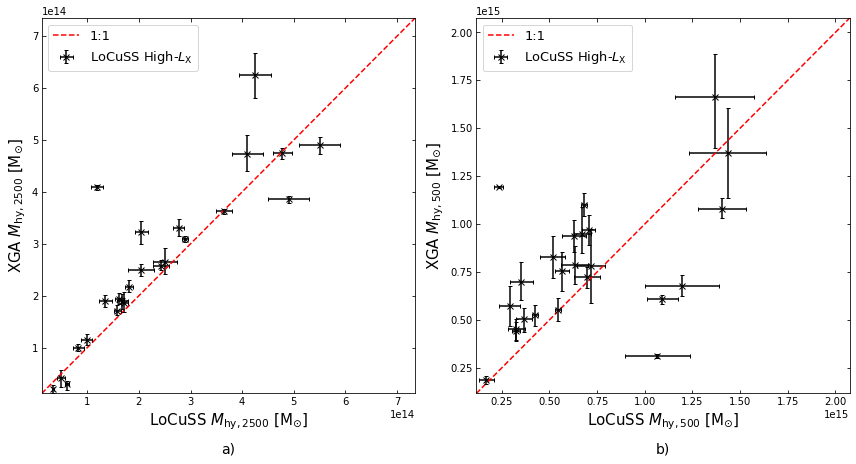

In [10]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_13_m2500, loc_sb_dblbeta_simpvikh_13_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

  0%|                                                                               | 0/30000 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/emcee-3.1.1-py3.8.egg/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████████| 30000/30000 [00:26<00:00, 1137.49it/s]


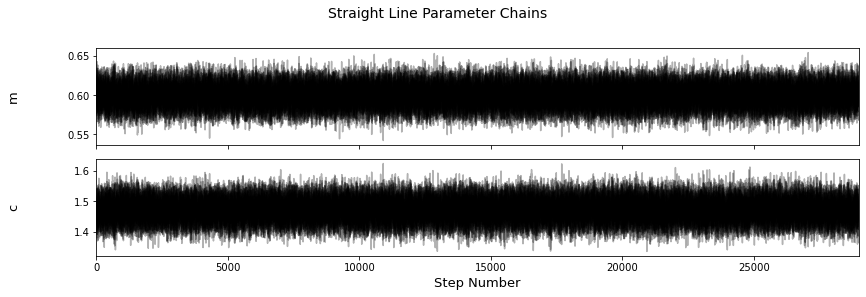

Removed no burn in


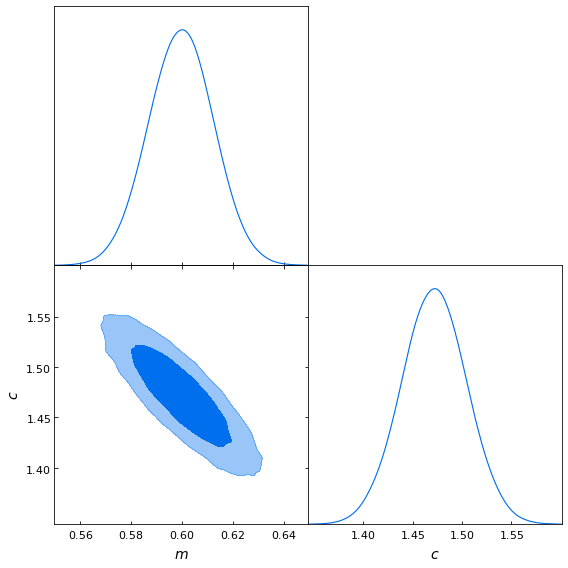

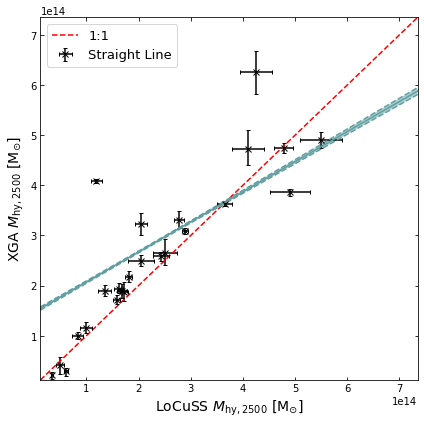

m=0.6 +0.013 -0.013 [1sig]
c=1.472 +0.033 -0.033 [1sig]


In [11]:
fit_comp(loc_lit_m2500s, loc_sb_dblbeta_simpvikh_13_m2500, [[-5, 5], [-5, 5]], 
         r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", view_chains=True,
         view_corner=True, norm=Quantity(1e+14, 'Msun'), linear=True, xscale='linear', yscale='linear')

  0%|                                                                               | 0/30000 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/emcee-3.1.1-py3.8.egg/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████████| 30000/30000 [00:26<00:00, 1133.72it/s]


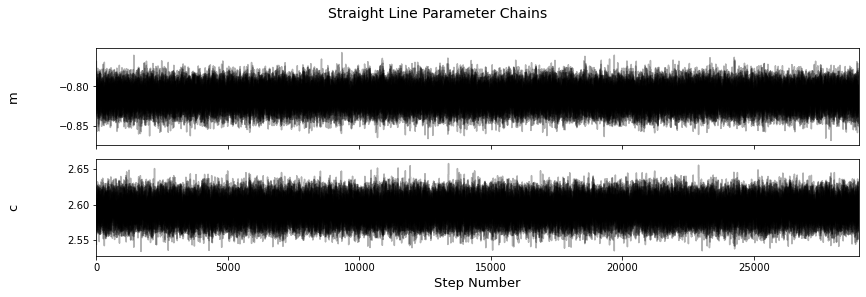

Removed no burn in


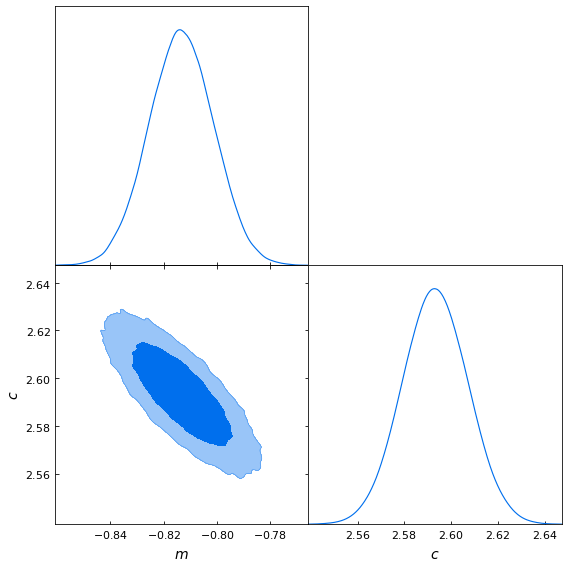

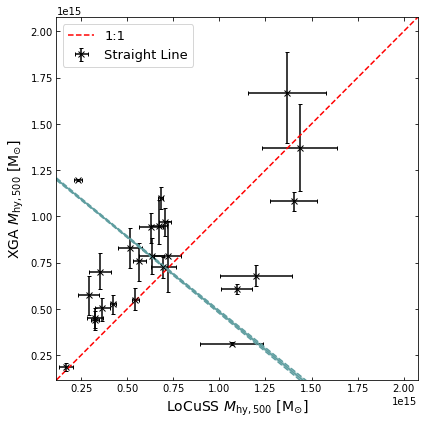

m=-0.813 +0.012 -0.012 [1sig]
c=2.593 +0.014 -0.014 [1sig]


In [12]:
fit_comp(loc_lit_m500s, loc_sb_dblbeta_simpvikh_13_m500, [[-5, 5], [-5, 5]], 
         r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]", view_chains=True,
         view_corner=True, norm=Quantity(5e+14, 'Msun'), linear=True, xscale='linear', yscale='linear')

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.2$R_{500}$

In [13]:
loc_sb_dblbeta_simpvikh_12_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.2, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Generating products of type(s) spectrum: 100%|████████████████████████████| 221/221 [1:54:25<00:00, 31.07s/it]
Generating products of type(s) annular spectrum set components: 100%|███| 2950/2950 [3:15:48<00:00,  3.98s/it]
Running XSPEC Fits:  92%|██████████████████████████████████████████████▊    | 538/586 [21:20<06:13,  7.79s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
loc_sb_dblbeta_simpvikh_12_m500 = []
loc_sb_dblbeta_simpvikh_12_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_12_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_12_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_12_m500.append(m)
        loc_sb_dblbeta_simpvikh_12_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_12_m500 = Quantity(loc_sb_dblbeta_simpvikh_12_m500)
loc_sb_dblbeta_simpvikh_12_m2500 = Quantity(loc_sb_dblbeta_simpvikh_12_m2500)

Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 45/45 [00:00<00:00, 49.60it/s]


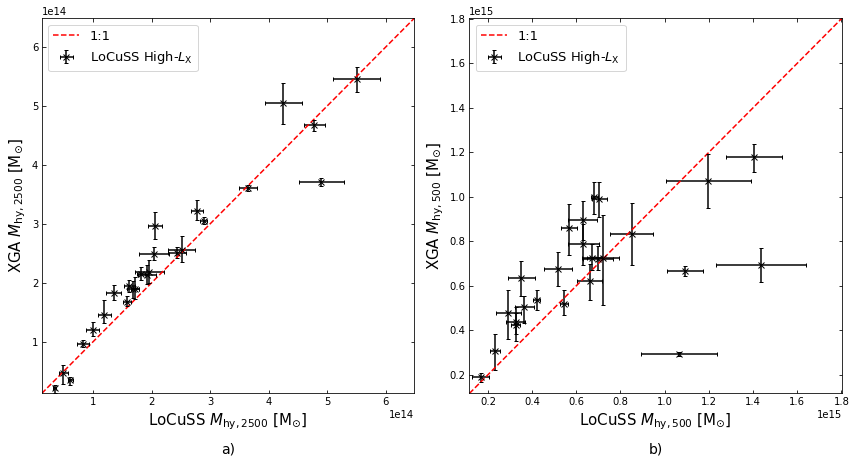

In [15]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_12_m2500, loc_sb_dblbeta_simpvikh_12_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.1$R_{500}$

In [16]:
loc_sb_dblbeta_simpvikh_11_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500*1.1, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_min_snr=30, freeze_met=False, 
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Generating products of type(s) spectrum: 100%|████████████████████████████| 221/221 [1:38:07<00:00, 26.64s/it]
Generating products of type(s) annular spectrum set components: 100%|███| 2866/2866 [2:48:25<00:00,  3.53s/it]
Running XSPEC Fits: 100%|███████████████████████████████████████████████████| 564/564 [43:37<00:00,  4.64s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell0963 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: Abell1451 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1041.2027271  1093.17632214 1754.06809745 1595.55407845 1700.54661102
 1796.3901292 ]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [457.37524229 298.61549024 415.28909209 382.28802877 388.22715215
 428.19917088]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▌       | 3/39 [01:18<15:34, 25.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1529.07228937  486.92828915 1408.40604141 1340.50012876 1428.27011627
 1429.38845356]


Fitting data, inverse Abel transforming, and measuring densities:  10%|▊       | 4/39 [01:41<14:25, 24.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 780.55957817 2111.51058568 1890.84577239 2091.422626   2186.38816474
 2281.87211769]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 5/39 [02:05<13:55, 24.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [285.53383064 670.2400393  332.70918995 225.47208037 483.55223023
 560.25696119]


Fitting data, inverse Abel transforming, and measuring densities:  15%|█▏      | 6/39 [02:30<13:35, 24.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [174.56384956 891.57486777 699.90942515 646.02953242 720.39146804
 855.57606662]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▋      | 8/39 [03:22<13:01, 25.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 213.1844673   442.39883654 1993.13006063 1844.78733713 1864.60118521
 1724.48356533]


Fitting data, inverse Abel transforming, and measuring densities:  23%|█▊      | 9/39 [03:50<13:00, 26.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [458.17275128 449.51501809 383.755069   386.55435359 411.77812716
 429.51131803]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 11/39 [04:42<12:06, 25.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [891.37440264 881.2706318  865.5445846  704.36115605 752.0023566
 852.33844238]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 13/39 [05:34<11:11, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1933.98690124 1240.92621104 2094.03721176 1999.59247445 2146.33710054
 2123.97596555]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▌    | 14/39 [06:01<10:49, 26.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [557.31749826 645.03006386 916.91360876 782.69604782 875.21960941
 965.54475388]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 15/39 [06:26<10:23, 25.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1062.74690698 1074.90564277  907.86354346  907.39809977  974.10136015
 1057.0194851 ]


Fitting data, inverse Abel transforming, and measuring densities:  41%|██▊    | 16/39 [06:51<09:50, 25.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 875.30504337  660.18432996 1257.06949315  870.10455085 1068.13735531
 1198.5032053 ]


Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 17/39 [07:17<09:21, 25.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 608.56434375  553.9725807  1711.50593291 1126.03306456 1181.0888944
 1331.55312541]


Fitting data, inverse Abel transforming, and measuring densities:  46%|███▏   | 18/39 [07:40<08:40, 24.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 243.32469216 1011.18824992 1801.4601958  2377.70374492 2375.73450975
 1778.71823838]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 22/39 [09:28<07:25, 26.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 779.13184964  523.56483452 1709.33377157 1612.86664934 1671.01486987
 1629.28758289]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████▏  | 23/39 [09:57<07:13, 27.10s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell1758N's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 24/39 [10:21<06:28, 25.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1172.01167199  525.43192746 2168.37824571  746.34061417  671.70827552
 2165.53379756]


Fitting data, inverse Abel transforming, and measuring densities:  64%|████▍  | 25/39 [10:47<06:03, 25.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 791.72007132  787.19079801 1329.43210984 1126.34630137  879.62413619
  958.35529603]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 29/39 [12:34<04:21, 26.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 809.36737571  876.73128345 2058.52038825 1457.45444924 1618.07272694
 2059.79675989]


Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 31/39 [13:24<03:25, 25.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1292.50175766  995.99436919 1288.57517358 1136.228041   1236.39899205
 1398.46675966]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 37/39 [16:08<00:53, 26.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1020.93443832  610.19208211  951.97277966  825.04676437  911.25109355
  989.75423781]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 38/39 [16:34<00:26, 26.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [547.77129599 509.66455616 533.8724917  306.1930914  397.06700538
 563.49594033]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 39/39 [16:58<00:00, 26.12s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [409.02672069 866.12745947 788.99982259 777.44700439 880.50017051
 956.5135014 ]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [462.80169264 796.92980641 409.38557822 624.58683394 300.44692002
 252.01586145]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.11052793 126.69124969 957.11363281 106.92540857 110.78651035
 319.91301354]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/45 [00:48<35:38, 48.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [492.89041405 588.79591876 270.79089342 541.35171365 282.78657724
 235.16186609]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [179.6609945  274.28233864 681.6488653  122.55571729 131.26088333
 338.26232769]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/45 [01:39<35:47, 49.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [343.78319407 711.55007974 349.47730598 490.42051286 269.23733166
 252.99152104]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [130.62412031 179.57773492 627.12385891 123.27996984 114.08152398
 335.31081604]


Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/45 [03:14<33:02, 48.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 343.76533137  365.99512602  428.33609352 1451.33933544  259.58255155
 1700.05832238]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/45 [04:00<31:46, 47.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [387.83304784 267.45106066 168.33102983 646.37516172 316.30997871
 681.20370234]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/45 [04:47<30:40, 47.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [103.93306537 107.83206694 547.0496306  114.78619783 118.77104693
 103.26573247]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [232.7912217  264.87870477 584.77172811 201.2346934  231.37717935
 306.45518615]


Generating Abell0267 hydrostatic mass profile:  16%|████▏                      | 7/45 [05:38<30:41, 48.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 422.45006486  772.55916185 1175.18190344  343.46074144  274.0673547
  341.75861033]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [111.66884423 113.34557792 487.64731305 115.97438788 110.45456195
 109.76845881]


Generating Abell0383 hydrostatic mass profile:  20%|█████▍                     | 9/45 [07:15<29:05, 48.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [539.77404684 677.77006851 561.67465963 457.16932248 326.61934409
 355.13992506]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.57112704  85.97635268 901.69038913  85.57894948  81.88036947
  82.72238203]


Generating Abell0521 hydrostatic mass profile:  22%|█████▊                    | 10/45 [08:06<28:47, 49.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [320.13566875 491.90978056 412.3749936  427.81356677 270.80910442
 315.99458881]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1627.59732887 1790.90369453 1088.74666747 1274.46962534 1641.63966872
 1138.35570394]


Generating Abell0586 hydrostatic mass profile:  24%|██████▎                   | 11/45 [08:54<27:49, 49.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 312.32401008  685.49936117 1121.05514336  295.58175092  256.0808673
  394.19187447]


Generating Abell0611 hydrostatic mass profile:  27%|██████▉                   | 12/45 [09:44<27:01, 49.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [364.64900548 729.94805694 511.96320385 550.33069347 395.89122238
 302.33705302]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 462.55785198  738.84636681 1017.1219022   387.89290403  218.15297738
  863.87395061]


Generating Abell0697 hydrostatic mass profile:  29%|███████▌                  | 13/45 [10:31<25:54, 48.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 261.773218    249.05330383  548.22478414   23.26377206  156.57674588
 2424.47120797]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  31%|██████▏             | 14/45 [11:23<25:35, 49.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [563.7944908  475.32096175 420.6332791  612.87664868 432.56911106
 467.82134307]


Generating Abell0750 hydrostatic mass profile:  33%|████████▋                 | 15/45 [12:10<24:23, 48.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 102.04835843  119.77848069 1056.79581768   97.74644251  105.2232872
  134.88254134]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 514.89187759 2240.33002303 2165.10997015  370.96953899  279.77859335
  806.4909018 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1345.60510717 1281.80078093 1087.44353711 1400.68251118  945.81555289
 1164.55947519]


Generating Abell0773 hydrostatic mass profile:  36%|█████████▏                | 16/45 [13:01<23:52, 49.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [601.62349459 939.89057487 283.95496366 704.19110601 303.59309384
 259.25761272]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 99.07797628  96.06505909 420.59245069 116.7091199  106.14460535
  98.59369248]


Generating Abell0781 hydrostatic mass profile:  38%|█████████▊                | 17/45 [13:48<22:50, 48.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [426.99237029 550.17818127 403.88657985 383.19751626 287.37044414
 370.30028997]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1174.96252168 1180.9415309   297.54248715  346.69379917 1187.33673743
  297.95693312]


Generating Abell0901 hydrostatic mass profile:  40%|██████████▍               | 18/45 [14:36<21:49, 48.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [542.79839088 712.777108   313.18353434 535.82947057 307.98394638
 347.63026722]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.65721019  81.67257186 832.99741231  81.29678297  74.51979448
  82.28563362]


Generating Abell0907 hydrostatic mass profile:  42%|██████████▉               | 19/45 [15:27<21:18, 49.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [220.98538234 211.71338674 124.87057693 601.06389997 184.56866875
 752.30797675]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.7872745   94.52332803 404.55908069  89.79947018  85.38127505
 101.20586719]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  47%|█████████▎          | 21/45 [16:19<20:04, 50.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1211.3027018  1503.19943455  947.03896369 1396.06844026  461.6684513
 1177.06093632]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.90775802 102.58043884 605.58799337  85.56040444 131.96720621
  59.20125901]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  51%|██████████▏         | 23/45 [17:08<13:59, 38.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:234: UserWarning: A mass of less than zero was measured by a hydrostatic mass profile, this is not physical and the profile is not valid.
  warn("A mass of less than zero was measured by a hydrostatic mass profile, this is not physical"
Generating Abell1689 hydrostatic mass profile:  53%|█████████████▊            | 24/45 [17:57<11:30, 32.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.00344957  81.08015689 786.58432224  82.35751832  82.49203717
  83.56077346]


Generating Abell1758N hydrostatic mass profile:  56%|█████████████▉           | 25/45 [18:51<12:30, 37.54s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:240: UserWarning: The density profile for Abell1758N could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating Abell1763 hydrostatic mass profile:  58%|███████████████           | 26/45 [18:51<11:53, 37.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [291.30089118 440.1544804  338.93055638 381.84192523 261.47001137
 241.20533971]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  95.20071002   97.17868791 1574.38391129  120.02577309  122.5666803
   98.98485221]


Generating Abell1835 hydrostatic mass profile:  60%|███████████████▌          | 27/45 [19:40<09:43, 32.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [675.48299638 734.50530976 514.11208729 850.91435701 296.44195609
 826.77307891]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  64%|████████████▉       | 29/45 [20:32<09:49, 36.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [402.72120398 496.7913308  764.38310678 407.30240996 316.95323763
 359.25714857]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 107.13983083   98.0311626  1258.73782189  115.09503172  132.57326982
   91.39740288]


Generating ZwCl1459.4+4240 hydrostatic mass profile:  69%|█████████████▊      | 31/45 [22:16<08:39, 37.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 345.88223644 1253.16199639  459.15136379  545.25372475  291.87401975
  297.49545204]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1160.75932125 1361.957699    470.11565679 1261.17153519 1140.72398819
  783.75874505]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  71%|██████████████▏     | 32/45 [23:04<08:33, 39.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [576.15451423 550.84620492 178.23051112 605.21940326 396.08276981
 472.14843146]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  67.39256247   67.5668513  1070.25489532   93.07733836   89.12981284
   45.77619522]


Generating Abell2111 hydrostatic mass profile:  73%|███████████████████       | 33/45 [23:58<08:39, 43.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 230.54535479  344.02018392  338.30995512  479.36836728  280.78802117
 1173.55785792]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 627.38060304 1157.989492   1441.75805288  383.35772469  246.40929647
 1290.34898039]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▊    | 36/45 [25:47<07:19, 48.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [507.67551036 386.55750811 172.90753169 528.82780819 261.87368717
 366.94652267]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.62015426  79.05925369 645.74985205  90.72073613  81.1726507
  71.38132728]


Generating Abell2261 hydrostatic mass profile:  82%|█████████████████████▍    | 37/45 [26:41<05:14, 39.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.78149308  79.21515284 415.99408806  81.19254024  80.66918722
  80.96459949]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  84%|████████████████▉   | 38/45 [27:32<04:53, 41.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.32003331  97.38732114 453.16099078 101.76946036 123.83920912
 100.59790883]


Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▏  | 39/45 [28:21<04:22, 43.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [472.458768   722.53968559 927.24143789 500.81583134 338.29607997
 350.5603316 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.03620083  88.83073185 514.87771368  83.20653274  81.44109343
  87.63488293]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 41/45 [29:11<03:02, 45.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [339.77009951 324.99411327 458.80541848 237.84700253 235.35296544
 211.98225708]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 42/45 [29:59<01:48, 36.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 299.12931834  392.80009    1037.97246552  204.88381413  140.9158659
  438.01861256]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [140.3008068  231.37664953 550.50436377 113.05059905 128.56520196
 279.98950105]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 44/45 [30:48<00:39, 39.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 254.67811195 1802.50817317 1275.32034454  640.11107102  238.94913312
  283.33151688]


Complete: 100%|███████████████████████████████████████████████████████████████| 45/45 [31:37<00:00, 42.17s/it]


In [17]:
loc_sb_dblbeta_simpvikh_11_m500 = []
loc_sb_dblbeta_simpvikh_11_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_11_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_11_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_11_m500.append(m)
        loc_sb_dblbeta_simpvikh_11_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_11_m500 = Quantity(loc_sb_dblbeta_simpvikh_11_m500)
loc_sb_dblbeta_simpvikh_11_m2500 = Quantity(loc_sb_dblbeta_simpvikh_11_m2500)

Measuring Masses for LoCuSS Clusters:  76%|██████████████████████████▍        | 34/45 [00:00<00:00, 49.66it/s]

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 45/45 [00:00<00:00, 46.96it/s]


In [18]:
print("{s} out of {t} R2500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_11_m2500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_11_m2500)))
print("{s} out of {t} R500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_11_m500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_11_m500)))

37 out of 45 R2500 mass measurements produced a result
37 out of 45 R500 mass measurements produced a result


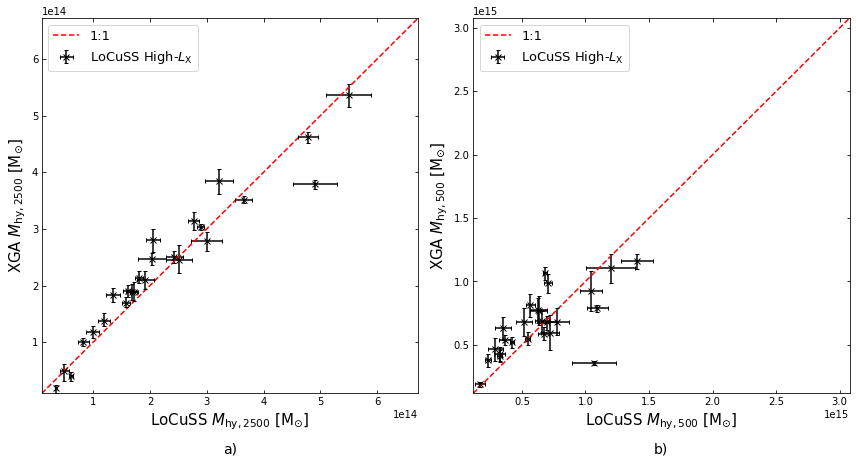

In [19]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_11_m2500, loc_sb_dblbeta_simpvikh_11_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'], 
                       savepath='../../outputs/figures/loc_sb_dblbeta_simpvikh_1.1r500_hymcomp.pdf')

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to $R_{500}$, cnt$_{\rm{min}}$=3000

In [20]:
loc_sb_dblbeta_simpvikh_1_min3000_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500, 'double_beta', 
                                                                'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 
                                                                'r500', freeze_met=False, 
                                                                temp_lo_en=Quantity(0.7, 'keV'), 
                                                                temp_hi_en=Quantity(10., 'keV'), 
                                                                temp_annulus_method='min_cnt', 
                                                                temp_min_cnt=Quantity(3000, 'ct'),
                                                                temp_use_combined=True)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for ZwCl0104.4+0048 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for ZwCl0857.9+2107 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for Abell2537 cannot be created, the data quality is too

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1367.91986246  777.80591262 1394.96492937 1276.89339512 1417.02525301
 1371.38596448]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 2/42 [00:52<17:34, 26.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [502.86231799 349.78269014 514.13774799 462.23365675 461.45427758
 528.85604088]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/42 [01:15<16:13, 24.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1713.27922375 1017.63094452 1796.75900461 1258.32179576 1374.47328594
 1449.96484354]


Fitting data, inverse Abel transforming, and measuring densities:  10%|▊       | 4/42 [01:38<15:10, 23.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 814.13481253 1851.5439963  1641.89321858 1709.48892789 1781.83739611
 1873.38386789]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▉       | 5/42 [02:02<14:47, 24.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [386.87583066 625.60095842 190.15649846 177.81533975 345.58324916
 316.17982152]


Fitting data, inverse Abel transforming, and measuring densities:  14%|█▏      | 6/42 [02:26<14:32, 24.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [559.07632677 479.69613879 944.00630902 571.99073594 998.65877891
 947.72861107]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▎      | 7/42 [02:52<14:29, 24.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [317.53896281 656.35187396 566.51113109 383.99244508 467.63533998
 535.18131341]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▌      | 8/42 [03:17<14:05, 24.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 223.02673334  298.97685148 1750.90171094 1628.04907278 1706.39652048
 1690.4415767 ]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 12/42 [05:05<13:10, 26.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [925.56062361 943.95023409 902.23746545 779.15625904 804.88593841
 870.57813137]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 13/42 [05:31<12:40, 26.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1037.3994732   188.84363917 1052.22017568  887.44640411 1037.87694949
 1023.13713947]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 14/42 [05:56<12:07, 25.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [756.32165651 766.59604471 659.51268401 830.81869148 849.26996651
 808.4730305 ]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▌    | 15/42 [06:21<11:35, 25.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1031.53681791  761.37097458 1516.974175   1206.95839117 1449.24740469
 1556.93456121]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 16/42 [06:47<11:07, 25.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 647.06713526  378.19016965 1730.90133789 1332.76528462 1382.59994948
 1538.58180448]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 17/42 [07:10<10:20, 24.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 557.57381876 1187.65323718 1976.66837986 2450.81496618 2437.9878476
 1861.64644567]


Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 20/42 [08:34<09:54, 27.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [457.20036244 439.0630919  372.24992177 385.45318524 395.66872436
 426.57868272]


Fitting data, inverse Abel transforming, and measuring densities:  50%|███▌   | 21/42 [09:02<09:38, 27.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 554.69674862  318.04424189 1811.04151687 1521.32146786 1267.67213875
 1802.11900712]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▊   | 23/42 [09:51<08:12, 25.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 766.7851243   694.40965716 2140.11384168 1226.25359114 1458.8409452
 2105.89320622]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 25/42 [10:45<07:28, 26.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 749.22615365  974.58014622 1604.44423825 1450.91478132 1300.78396888
 1334.96326547]


Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 28/42 [12:06<06:14, 26.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [670.5023967  672.04171818 651.38539319 593.8086154  634.08134806
 656.97745407]


Fitting data, inverse Abel transforming, and measuring densities:  71%|█████  | 30/42 [12:58<05:13, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 535.05132176  808.98774504 1518.66796742 1279.44092517 1279.4719716
 1548.52543372]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 32/42 [13:49<04:17, 25.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 999.35287175  752.16789356 1058.17375712 1162.63729353 1195.33539881
 1114.40391132]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 39/42 [16:57<01:18, 26.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1413.429514    893.72317278 1415.13607858 1234.48214885 1348.1243917
 1413.66743652]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 41/42 [17:46<00:25, 25.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 835.99024407  896.7826556  1560.98175043 1260.28616216 1212.75134172
 1520.88097279]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 42/42 [18:10<00:00, 25.95s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 511.93589055  333.08433406 1415.01557341 1106.31580186  712.77936839
 1405.62379385]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 604.11423546 1308.86156567  407.06811687  754.32515448  273.41648051
  260.794635  ]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/45 [00:48<35:13, 48.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [431.39893    589.71085809 255.73684638 592.50945464 298.80267385
 242.59163715]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/45 [01:38<35:35, 49.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [180.76440417 262.16031457 712.8770615  131.33253612 165.71237056
 358.7070427 ]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [339.42015915 733.162742   398.76796141 506.15868978 277.38124018
 210.28264054]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 136.79438551  300.58395618 1153.07083491  131.77076514  122.16336894
  872.37187023]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/45 [02:26<34:04, 48.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [349.2333308  384.15238654 421.94656971 258.49980064 256.09422454
 268.98965185]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [616.40833338 642.51730559 736.11223759 606.34668161 360.64122212
 712.79915409]


Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/45 [03:12<32:35, 47.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 436.30947969  499.36713859  439.92578639  747.57630472  295.69487513
 1137.83779676]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/45 [03:59<31:33, 47.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [294.6397987  246.04583222 178.66700942 532.20543241 290.22746038
 337.70685972]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/45 [04:44<30:17, 46.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [199.84153743 130.98925194 643.26129318 435.59558754 325.92015591
 122.09831992]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 987.18220475 1275.04192076 1608.4594227   729.52028083  948.96037689
 1386.47730057]


Generating Abell0267 hydrostatic mass profile:  16%|████▏                      | 7/45 [05:35<30:26, 48.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [286.65333929 454.93838668 724.68746047 304.84426975 311.77242238
 290.39589933]


Generating Abell0291 hydrostatic mass profile:  18%|████▊                      | 8/45 [06:23<29:33, 47.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  96.3642005    99.87776661 1109.38135858   92.9504917   127.25647234
  105.9981448 ]


Generating Abell0383 hydrostatic mass profile:  20%|█████▍                     | 9/45 [07:13<29:08, 48.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [561.65046666 679.65752141 638.77190292 548.3582075  363.98606451
 500.87087782]


Generating Abell0521 hydrostatic mass profile:  22%|█████▊                    | 10/45 [08:04<28:50, 49.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.25446426  89.87251448 837.71569949  91.95588921  93.26310243
  90.90922746]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [495.81431488 518.58781474 318.38491792 529.19318775 291.77604488
 281.83563714]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1662.77849401 1687.89018634  982.54163436  999.89548429 1639.79824819
  963.6898819 ]


Generating Abell0586 hydrostatic mass profile:  24%|██████▎                   | 11/45 [08:52<27:45, 48.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [356.14915161 529.18156538 787.37500032 338.86857302 285.09804619
 363.69637396]


Generating Abell0611 hydrostatic mass profile:  27%|██████▉                   | 12/45 [09:41<27:01, 49.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [443.10949698 838.70061482 542.13820157 575.92043669 442.0796967
 343.86220446]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [175.38364364 256.92762434 452.01089329 158.35347361 135.01767473
 311.75357673]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  31%|██████▏             | 14/45 [10:28<25:00, 48.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [658.96851465 887.91780214 646.00402434 680.1683809  364.23974721
 571.31000043]


Generating Abell0750 hydrostatic mass profile:  33%|████████▋                 | 15/45 [11:15<18:27, 36.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  96.19764969   97.68718833 1100.53191293  107.27162181  108.85989007
  109.64501456]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 432.68719575 1492.19645822 1622.26794136  437.93375332  471.14147259
  434.78682481]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1234.57676409 1577.61762615 1905.1136261   950.90410212  965.97419032
 1855.24845152]


Generating Abell0773 hydrostatic mass profile:  36%|█████████▏                | 16/45 [12:06<19:27, 40.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 587.94373759 1112.7308827   451.85046721  803.94568624  346.28228609
  318.24780661]


Generating Abell0781 hydrostatic mass profile:  38%|█████████▊                | 17/45 [12:53<19:39, 42.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 92.67857049  92.70527474 845.1400276  108.91077739 136.51764693
 101.35595463]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:240: UserWarning: The density profile for Abell0781 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating Abell0901 hydrostatic mass profile:  40%|██████████▍               | 18/45 [12:53<18:57, 42.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [669.89515976 721.50515962 259.95749642 711.06362206 309.56830953
 346.43718748]


Generating Abell0907 hydrostatic mass profile:  42%|██████████▉               | 19/45 [13:44<15:08, 34.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.65923271  84.14581881 800.78579713  78.11552026  74.51167176
  80.020448  ]


Generating Abell0963 hydrostatic mass profile:  44%|███████████▌              | 20/45 [14:37<16:18, 39.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 408.63993811  759.57293086 1034.33684512  506.1071151   358.48408751
  433.16947432]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [106.47109257 104.2482595  624.03644977 102.04676527 125.96748684
 100.34722056]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  47%|█████████▎          | 21/45 [15:24<16:29, 41.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [744.51324347 778.40599569 372.44776584 743.36331455 419.25359981
 470.23577459]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 84.92266874  94.37767854 425.04805238  87.73689572 115.05235833
  72.2491719 ]


Generating Abell1451 hydrostatic mass profile:  49%|████████████▋             | 22/45 [16:14<16:38, 43.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 555.23297684 1649.75944382  276.6380919  1055.11426468  303.20092131
  381.58276055]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [105.46868647 113.03920203 915.13639053 102.48304533 113.48189482
 169.39621409]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  51%|██████████▏         | 23/45 [17:03<16:27, 44.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [612.90919835 601.18741745 205.36895102 480.27409182 444.7390166
 261.91444611]


Generating Abell1689 hydrostatic mass profile:  53%|█████████████▊            | 24/45 [17:51<16:04, 45.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 72.53590531  75.93800748 596.69753106  79.38707037  80.40098875
  78.41809926]


Generating Abell1763 hydrostatic mass profile:  58%|███████████████           | 26/45 [18:44<15:12, 48.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [586.4698899  985.74524975 314.17290058 774.45699119 300.81263148
 372.2959082 ]


Generating Abell1835 hydrostatic mass profile:  60%|███████████████▌          | 27/45 [19:32<11:10, 37.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 102.60396021  100.99898035 1025.56347616  139.76441926  142.16794176
   97.9841188 ]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1024.71556236  828.328015    636.96858434 1415.520069    343.59582478
 1783.5920696 ]


Generating Abell1914 hydrostatic mass profile:  62%|████████████████▏         | 28/45 [20:25<11:36, 40.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [627.83358848 977.15710694 416.88461751 943.68216189 481.22097213
 355.1079772 ]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 285.82572588 1407.36939982 1861.9912922   187.83417019  223.02378561
  206.71983267]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  64%|████████████▉       | 29/45 [21:12<11:21, 42.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [520.0412322  703.59195628 653.16907798 508.89008671 363.92374134
 390.68767438]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▎        | 30/45 [22:01<11:02, 44.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  90.32580498   88.89675822 1351.83030467   97.75327768  129.79032968
   88.51811848]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [329.13988768 505.53831156 613.48480003 374.3925931  237.89348812
 238.51110734]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 82.90796527  84.83039666 501.93520136  90.07860281  85.34657837
  90.14719776]


Generating ZwCl1459.4+4240 hydrostatic mass profile:  69%|█████████████▊      | 31/45 [22:56<11:00, 47.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 372.3718053  1309.08169954  645.50986499  525.36961221  291.13571554
  888.50784201]


Generating RXCJ1504.1-0248 hydrostatic mass profile:  71%|██████████████▏     | 32/45 [23:43<10:11, 47.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1711.86386072 1796.12061807 1979.50139206 1125.92916213 1742.68337603
 1727.71915637]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 917.41726559 1054.49329591  298.19491628  984.72026348  393.99406489
  832.42220166]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 56.20021313  70.56593912 832.39568519  80.62830567  81.64446168
  40.58853557]


Generating Abell2111 hydrostatic mass profile:  73%|███████████████████       | 33/45 [24:37<09:49, 49.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 356.22279093  363.17478241  283.8837926   627.13176577  262.22636351
 1919.56026132]


Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▋      | 34/45 [25:26<09:01, 49.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [319.04851637 669.76141902 955.99829448 207.59075491 151.31831036
 811.6436626 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.72186951  89.2764603  501.32946809  90.50900893  98.78874303
  75.55486171]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▊    | 36/45 [26:25<07:48, 52.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [549.33741726 369.68987081 157.75358653 522.55142422 207.58338655
 353.50938193]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 76.88448676  82.89112185 574.55538253  83.61974409  84.79856823
  71.33017204]


Generating Abell2261 hydrostatic mass profile:  82%|█████████████████████▍    | 37/45 [27:20<05:26, 40.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.13363991  86.01102238 615.3694821   85.95364972  78.39193402
  81.65756287]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  84%|████████████████▉   | 38/45 [28:10<05:01, 43.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [469.04357368 432.07872704 338.99817011 447.64589682 244.41264526
 312.39466992]


Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▏  | 39/45 [28:59<04:27, 44.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.41820679 107.3980706  400.5662636  105.68884105 137.59164817
 109.41801134]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 527.4153216   779.53138082 1104.51633733  629.66930109  387.59726218
  469.58963717]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.64496719  82.1980696  575.7572051   94.14541596  91.97447716
  85.37299393]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████   | 40/45 [29:49<03:50, 46.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  95.17269254   87.48845849 1035.83219028   87.26084912   85.31111849
   83.96865891]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 41/45 [30:42<03:11, 47.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [308.3801088  536.76742138 466.39771625 373.73665864 232.95024379
 251.06296239]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 42/45 [31:30<02:23, 47.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [358.57156453 572.2982205  956.47642122 227.53547742 164.39309761
 658.17390367]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [146.38465337 223.55330865 458.94269318 106.75359435 149.53805899
 269.16403762]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████▊ | 43/45 [32:19<01:36, 48.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [549.61570794 609.52690592 362.40482449 512.67224188 378.37507591
 291.67410845]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 44/45 [33:07<00:48, 48.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [525.72901981 597.07354281 372.17503485 467.54539628 340.44666465
 314.52020744]


Complete: 100%|███████████████████████████████████████████████████████████████| 45/45 [33:54<00:00, 45.22s/it]


In [21]:
loc_sb_dblbeta_simpvikh_1_mc3000_m500 = []
loc_sb_dblbeta_simpvikh_1_mc3000_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_1_min3000_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_1_min3000_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_1_mc3000_m500.append(m)
        loc_sb_dblbeta_simpvikh_1_mc3000_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_1_mc3000_m500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc3000_m500)
loc_sb_dblbeta_simpvikh_1_mc3000_m2500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc3000_m2500)

Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 45/45 [00:01<00:00, 42.30it/s]


In [22]:
print("{s} out of {t} R2500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc3000_m2500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc3000_m2500)))
print("{s} out of {t} R500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc3000_m500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc3000_m500)))

41 out of 45 R2500 mass measurements produced a result
41 out of 45 R500 mass measurements produced a result


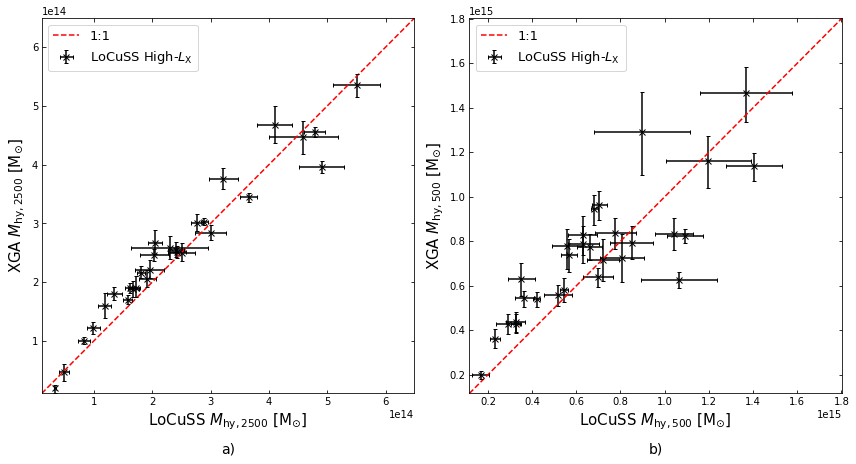

In [28]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_1_mc3000_m2500, loc_sb_dblbeta_simpvikh_1_mc3000_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'], 
                       savepath='../../outputs/figures/loc_sb_dblbeta_simpvikh_1r500_mc3000_hymcomp.pdf')

## Bodge

In [24]:
loc_sb_dblbeta_simpvikh_1_1500mc_mp = inv_abel_dens_onion_temp(locuss_srcs, locuss_srcs.r500, 'double_beta', 
                                                         'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                         temp_annulus_method='min_cnt', temp_min_cnt=Quantity(1000, 'ct'), 
                                                         freeze_met=False, temp_use_combined=False,
                                                         temp_lo_en=Quantity(0.7, 'keV'), 
                                                         temp_hi_en=Quantity(10., 'keV'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for Abell2813 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for ZwCl0104.4+0048 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:291: UserWarning: The requested annuli for Abell0267 cannot be created, the data quality is too low. 

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 910.263939    637.30063786 1028.99508118 1255.5371673  1309.92105076
 1025.96158106]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▎       | 2/43 [00:52<18:09, 26.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [551.23805483 413.12115033 513.34054529 481.16987444 472.64951886
 523.85900733]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/43 [01:17<17:00, 25.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1924.69569903  903.24479293 2040.71613847 1855.02882425 1989.38554006
 2032.65396297]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/43 [01:39<15:50, 24.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 909.34007118 2047.18121858 2080.50663898 2042.48251432 2139.0323922
 2269.56432315]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▉       | 5/43 [02:03<15:22, 24.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [448.89638252 629.97839286 285.58992551 288.51325657 401.25950543
 258.975453  ]


Fitting data, inverse Abel transforming, and measuring densities:  14%|█       | 6/43 [02:28<15:04, 24.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [458.09814681 411.62826721 722.3403007  510.88585287 740.65320062
 723.93886728]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▎      | 7/43 [02:54<14:57, 24.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [172.07178398 744.93121027 774.29788527 665.11876936 687.28724263
 813.47930598]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▍      | 8/43 [03:19<14:30, 24.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 217.82403526  426.3041832  2150.52762261 2053.47386895 2100.59581928
 2086.6468539 ]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▋      | 9/43 [03:46<14:32, 25.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [527.16464016 520.17696294 416.38530071 336.96712069 390.45749312
 471.77582661]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 12/43 [05:06<13:38, 26.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 974.90008316  991.58169419  998.89850687  968.74989516 1000.95525877
  985.7180704 ]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██     | 13/43 [05:31<12:57, 25.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1141.34257215  663.73734729 1737.29570737 1479.98761256 1725.60202323
 1798.78888243]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 14/43 [05:56<12:23, 25.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1830.94775997  842.7995582  1842.13720551 1684.2023975  1792.57989229
 1796.53679508]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 15/43 [06:21<11:56, 25.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [760.3427992  787.23197896 696.36429412 760.81295494 802.58110405
 789.49619817]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 16/43 [06:46<11:25, 25.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1272.53393872 1112.87405164 1709.33076908 1412.55120882 1638.76233699
 1756.91259753]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 17/43 [07:11<10:56, 25.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 609.99048521  487.46819716 1613.93790464 1133.21562592 1205.54419464
 1326.22419193]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 18/43 [07:34<10:13, 24.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 626.67698483 1051.39064543 1865.65989212 2427.12639465 2420.06006934
 1870.55254227]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 21/43 [08:57<09:47, 26.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [487.3743675  493.9318063  440.79827668 443.39804353 454.90666885
 478.85933883]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 22/43 [09:26<09:31, 27.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 863.2100268   235.15817838 2172.24718071 1976.56384924 1739.75523727
 2137.76664364]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 24/43 [10:14<08:05, 25.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 959.6869103   734.33703024 2078.68423756 1273.26772242 1395.01826547
 2057.77506766]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 26/43 [11:08<07:26, 26.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 734.68788259  718.00823298 1503.5958039  1252.15639439 1050.96374686
 1060.61265487]


Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 29/43 [12:28<06:12, 26.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [614.11940554 612.31831239 569.98049479 474.01018841 525.81978475
 572.42094994]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 31/43 [13:21<05:14, 26.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 400.05685817  544.00349652  952.95968141 1493.97179234 1442.47404162
 1011.32512783]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▎ | 33/43 [14:12<04:17, 25.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1312.74886747 1037.69906259 1383.77184074 1169.79047753 1253.15117466
 1400.87933992]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 40/43 [17:18<01:17, 25.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1219.15345408  801.97843325 1203.35958289 1041.3971188  1154.99763417
 1240.57757172]


Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 41/43 [17:43<00:51, 25.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [429.8047893  429.91424842 420.94573677 394.70236161 445.05657125
 557.35016733]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 42/43 [18:07<00:25, 25.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1126.67235154  889.21157273 1818.40555831 1374.4944474  1168.92966141
 1800.73300037]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 43/43 [18:31<00:00, 25.84s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 494.12612507  641.68953689 1409.58634937 1209.78282859  633.99496369
 1383.28999438]


Generating Abell2697 hydrostatic mass profile:   0%|                                   | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [609.91689727 986.9666392  563.40671055 779.6931254  343.48918167
 268.39651922]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 97.68291749 111.78536468 416.49199775 118.25632307 128.68794392
 185.70813918]


Generating Abell0068 hydrostatic mass profile:   2%|▌                          | 1/45 [00:47<34:47, 47.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [498.35767824 620.3145721  360.62854925 588.21033648 318.48165646
 313.41525726]


Generating Abell2813 hydrostatic mass profile:   4%|█▏                         | 2/45 [01:37<35:10, 49.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [194.18963554 268.82002249 561.01415551 135.88472915 160.52726106
 327.12870276]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 815.8282421  1160.32968139  438.06909816 1068.57420505  397.49880989
  393.50026071]


Generating Abell0115S hydrostatic mass profile:   7%|█▋                        | 3/45 [02:24<33:33, 47.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 114.35730488  212.07382732 1078.44156866  110.31732071  106.62071533
  685.2977942 ]


Generating Abell141 hydrostatic mass profile:   9%|██▍                         | 4/45 [03:10<32:19, 47.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [790.47158396 828.08115393 824.2280695  605.70826121 375.61983025
 822.26896645]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 518.73179843 1516.93221237 1578.05269268  500.91604934  362.19170392
  751.71822474]


Generating ZwCl0104.4+0048 hydrostatic mass profile:  11%|██▎                  | 5/45 [03:56<31:16, 46.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [352.46183126 274.89563956 149.18053953 446.33945568 252.59936475
 308.98118193]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 130.38876908  126.7845819  1360.38584982  228.94088321  188.35844066
  130.58994083]


Generating Abell0209 hydrostatic mass profile:  13%|███▌                       | 6/45 [04:42<30:13, 46.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 615.05277772 1067.52326066 1316.11189106  474.78216168  601.2285657
 1234.68922328]


Generating Abell0267 hydrostatic mass profile:  16%|████▏                      | 7/45 [05:33<30:18, 47.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [492.98806304 575.86045948 439.73162894 498.52030106 382.14428459
 390.28101297]


Generating Abell0291 hydrostatic mass profile:  18%|████▊                      | 8/45 [06:20<29:26, 47.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 111.21429877  108.5294411  1122.32889677  109.52724753  114.03010172
  105.19963629]


Generating Abell0383 hydrostatic mass profile:  20%|█████▍                     | 9/45 [07:09<28:48, 48.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [644.67943499 779.34085709 672.27668246 595.94221749 370.06049915
 517.13561384]


Generating Abell0521 hydrostatic mass profile:  22%|█████▊                    | 10/45 [08:00<28:33, 48.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 74.86285648  79.49241402 936.77356297  83.98622446  85.32978942
  80.5283889 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1141: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1764.05379536 1811.06919005 1438.88068715 1568.18146387 1696.88815279
 1440.70632951]


Generating Abell0586 hydrostatic mass profile:  24%|██████▎                   | 11/45 [08:28<24:07, 42.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 374.75535995 1425.28367339 1724.10988795  542.48638309  364.31060071
  853.55663654]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 94.44621305  96.94359611 511.66527843 104.78546434 113.74284159
  95.98435635]


Generating Abell0611 hydrostatic mass profile:  27%|██████▉                   | 12/45 [09:17<24:26, 44.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [296.88170037 534.30881592 435.42275077 416.76367447 309.04570183
 256.58770686]


Generating Abell0697 hydrostatic mass profile:  29%|███████▌                  | 13/45 [10:03<24:00, 45.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [133.66196776 167.52308271 532.70276998 126.16581297 116.49555804
 202.00791535]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 401.28122718 1159.95294127  274.79176071  734.66657206  342.11525436
  290.17830349]


Generating ZwCl0857.9+2107 hydrostatic mass profile:  31%|██████▏             | 14/45 [10:51<23:39, 45.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 120.69612702  265.31238455 1382.98450063  113.08778387  115.5685487
 1007.98847672]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 712.94461837 1703.46005498  686.3414985   915.37188223  375.78952167
  919.22084104]


Generating Abell0750 hydrostatic mass profile:  33%|████████▋                 | 15/45 [11:37<23:00, 46.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.23115485 107.28448179 955.73427045 116.16938672 113.82159181
 125.74213951]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 646.68651226 1105.29835489  955.92333904  662.94051243  425.26861247
  532.76101172]


Generating Abell0773 hydrostatic mass profile:  36%|█████████▏                | 16/45 [12:26<22:36, 46.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1696.63048087 1748.71565442 1828.31215906 1438.48840746  964.10032267
 1809.63739488]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 778.42718538 1236.35446267  439.6619473  1118.42607347  384.29928277
  339.108512  ]


Generating Abell0781 hydrostatic mass profile:  38%|█████████▊                | 17/45 [13:13<21:50, 46.81s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:240: UserWarning: The density profile for Abell0781 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating Abell0901 hydrostatic mass profile:  40%|██████████▍               | 18/45 [13:13<21:03, 46.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [103.46463298 101.75147434 659.69912088 111.11424423 114.98376795
 101.90021506]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [632.17021655 642.05234185 335.31792612 702.65900871 417.78953362
 360.34028255]


Generating Abell0907 hydrostatic mass profile:  42%|██████████▉               | 19/45 [14:03<15:57, 36.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.05870085  87.31942451 867.13757329  85.95764795  81.04762325
  86.78962365]


Generating Abell0907 hydrostatic mass profile:  44%|███████████▌              | 20/45 [14:55<16:56, 40.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 85.62577495  95.73038385 446.54147015  86.6691028   88.51003911
 101.72367389]


Generating Abell0963 hydrostatic mass profile:  44%|███████████▌              | 20/45 [14:55<16:56, 40.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 363.49955653  526.58017451  876.36532122  908.70563925  363.19511179
 1956.42841086]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.85195323  95.67947514 776.31128149  89.76919182 115.33501581
  97.35318079]


Generating ZwCl1021.0+0426 hydrostatic mass profile:  47%|█████████▎          | 21/45 [15:42<16:54, 42.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1173.78486912 1361.06648217  859.71835706 1272.0802169   455.88692108
  998.80726354]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.14262583  99.10236163 627.11798276  94.50656712 124.98670259
  66.88093563]


Generating Abell1451 hydrostatic mass profile:  49%|████████████▋             | 22/45 [16:30<16:49, 43.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 425.58528978  491.51360199  298.19813797  529.20134309  277.96582566
 1857.73087759]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [107.3769993  111.82996483 799.26334987 105.41531293 118.78073315
 148.16297879]


Generating ZwCl1231.4+1007 hydrostatic mass profile:  51%|██████████▏         | 23/45 [17:19<16:33, 45.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [402.74759921 523.52026664 357.54127626 481.92219693 384.41141186
 321.26453963]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [441.84745465 435.08554626 178.50480948 441.14369809 335.85565952
 230.01030099]


Generating Abell1689 hydrostatic mass profile:  53%|█████████████▊            | 24/45 [18:06<16:04, 45.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 79.86524497  78.85057283 830.99612223  87.96567541  88.85751341
  80.54459763]


Generating Abell1763 hydrostatic mass profile:  58%|███████████████           | 26/45 [18:59<15:11, 47.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [578.50263588 836.84888431 392.44874842 646.0646408  308.24047262
 281.14962421]


Generating Abell1835 hydrostatic mass profile:  60%|███████████████▌          | 27/45 [19:47<11:06, 37.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [104.76016069 105.20654242 678.3618266  109.6235203  111.25583174
 107.16815557]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [498.71315542 512.00637361 453.89232768 753.91392973 248.3631287
 991.03376503]


Generating Abell1914 hydrostatic mass profile:  62%|████████████████▏         | 28/45 [20:40<11:33, 40.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 776.34936357 1064.72177078  337.30077709 1156.48485194  537.04908151
  342.77248757]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [340.37741575 776.03524499 530.44119301 156.51458986 167.5442326
 167.94360525]


Generating ZwCl1454.8+2233 hydrostatic mass profile:  64%|████████████▉       | 29/45 [21:28<11:22, 42.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [478.97424347 596.97418871 719.54996065 579.2501317  360.53250231
 480.08784558]


Generating Abell2009 hydrostatic mass profile:  67%|█████████████████▎        | 30/45 [22:15<10:59, 43.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 102.2573066   103.85864767 1271.71433062  117.24822321  131.11798228
  101.98863107]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [504.61950965 879.53638988 728.37757581 639.53968472 353.83611117
 414.95889625]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 91.33381744  86.69626036 445.75677376  85.11091698  75.01310062
  84.75169801]


Generating ZwCl1459.4+4240 hydrostatic mass profile:  69%|█████████████▊      | 31/45 [23:09<10:53, 46.69s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1141: UserWarning: simple_vikhlinin_temp already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Generating RXCJ1504.1-0248 hydrostatic mass profile:  71%|██████████████▏     | 32/45 [23:36<08:56, 41.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1253.94720921 1375.16508377 1935.7433978   827.75872195 1280.9093497
 1684.61422785]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1053.71207781 1143.0588971   290.68719775 1085.70588458  480.99296045
  975.15333158]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 58.90988768  70.26844817 968.55716303  91.07804582  93.84993527
  33.63258444]


Generating Abell2111 hydrostatic mass profile:  73%|███████████████████       | 33/45 [24:30<08:57, 44.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 404.17307188  617.90420826  847.91283243 1157.00475156  312.85674472
 1902.47781643]


Generating Abell2204 hydrostatic mass profile:  76%|███████████████████▋      | 34/45 [25:18<08:24, 45.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.9414415   92.1050242  457.55370232  83.08825543  93.58387442
  84.98867806]


Generating RXJ1720.1+2638 hydrostatic mass profile:  80%|████████████████▊    | 36/45 [26:16<07:23, 49.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1018.19083431 1062.08911346  159.37301137 1109.2616996   254.50450156
 1263.38049261]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 71.41305104  71.17747084 931.01244259  73.9702161   77.92971945
  65.92836502]


Generating RXCJ2102.1-2431 hydrostatic mass profile:  84%|████████████████▉   | 38/45 [27:59<04:50, 41.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 92.29598719  92.70866359 612.96326406  90.30917197  85.96509507
  91.99497824]


Generating RXJ2129.6+0005 hydrostatic mass profile:  87%|██████████████████▏  | 39/45 [28:48<04:20, 43.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 88.92246753  83.4372109  493.17789984  96.25844361 136.55989005
  84.65344832]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [543.59103778 787.91126971 766.96868089 477.768012   305.91506499
 387.50582696]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 80.89232375  82.7116843  472.1888275   80.44473738  80.55580914
  82.69637046]


Generating Abell2390 hydrostatic mass profile:  89%|███████████████████████   | 40/45 [29:38<03:46, 45.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.14739123  85.62145974 501.55128548  86.48964964  87.68456356
  82.78491681]


Generating Abell2537 hydrostatic mass profile:  91%|███████████████████████▋  | 41/45 [30:30<03:08, 47.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [303.832646   492.69093838 599.38372784 399.36348721 296.37696302
 299.58817418]


Generating Abell2552 hydrostatic mass profile:  93%|████████████████████████▎ | 42/45 [31:18<02:22, 47.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 550.04370097  848.5869751  1008.59784878  350.01486352  223.27023725
  962.97382119]


Generating Abell2631 hydrostatic mass profile:  96%|████████████████████████▊ | 43/45 [32:07<01:35, 47.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 999.80076204 1677.98845572 2058.26589261  537.94999426 1120.57862633
 1750.61343415]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [413.98654867 814.0844575  390.68567721 713.27535157 321.6701884
 293.0858388 ]


Generating Abell2645 hydrostatic mass profile:  98%|█████████████████████████▍| 44/45 [32:55<00:47, 47.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [449.13034703 603.32050829 366.0991421  463.8326079  309.41174955
 323.88803839]


Complete: 100%|███████████████████████████████████████████████████████████████| 45/45 [33:42<00:00, 44.94s/it]


In [25]:
loc_sb_dblbeta_simpvikh_1_mc1500_m500 = []
loc_sb_dblbeta_simpvikh_1_mc1500_m2500 = []

with tqdm(desc='Measuring Masses for LoCuSS Clusters', total=len(loc_sb_dblbeta_simpvikh_1_1500mc_mp)) as onwards:
    for mp in loc_sb_dblbeta_simpvikh_1_1500mc_mp:
        if mp is not None:
            rel_src = locuss_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
            if m[0] < Quantity(1e+13, 'Msun'):
                m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
                m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            else:
                m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        loc_sb_dblbeta_simpvikh_1_mc1500_m500.append(m)
        loc_sb_dblbeta_simpvikh_1_mc1500_m2500.append(m2500)
        
        onwards.update(1)

loc_sb_dblbeta_simpvikh_1_mc1500_m500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc1500_m500)
loc_sb_dblbeta_simpvikh_1_mc1500_m2500 = Quantity(loc_sb_dblbeta_simpvikh_1_mc1500_m2500)

Measuring Masses for LoCuSS Clusters: 100%|███████████████████████████████████| 45/45 [00:01<00:00, 41.34it/s]


In [26]:
print("{s} out of {t} R2500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc1500_m2500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc1500_m2500)))
print("{s} out of {t} R500 mass measurements produced a "\
      "result".format(s=np.isfinite(loc_sb_dblbeta_simpvikh_1_mc1500_m500[:, 0]).sum(), 
                      t=len(loc_sb_dblbeta_simpvikh_1_mc1500_m500)))

42 out of 45 R2500 mass measurements produced a result
42 out of 45 R500 mass measurements produced a result


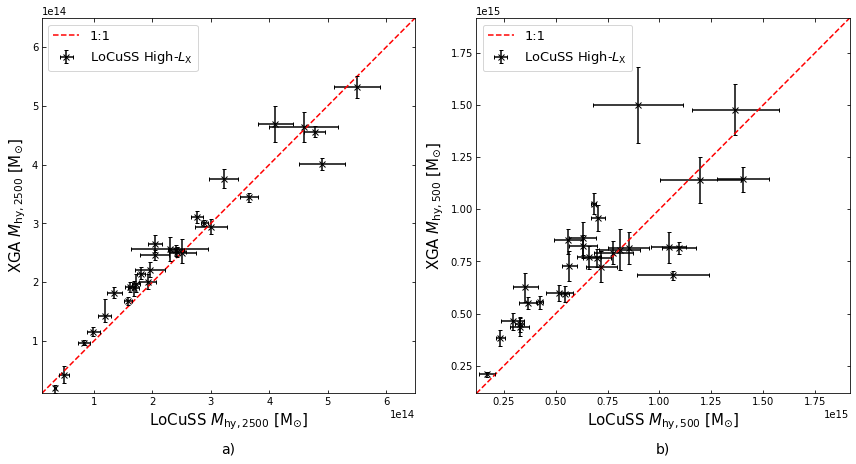

In [27]:
direct_comparison_plot([loc_lit_m2500s, loc_lit_m500s], 
                       [loc_sb_dblbeta_simpvikh_1_mc1500_m2500, loc_sb_dblbeta_simpvikh_1_mc1500_m500], 
                       [r"LoCuSS $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{hy, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{hy, 2500}}$ [M$_{\odot}$]", r"XGA $M_{\rm{hy, 500}}$ [M$_{\odot}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6.5), ['linear', 'linear'], ['linear', 'linear'])